# Figure 5bcd Loback et al. 

We remove the hard limits on weight change as these are redundant to learning rate and difficult to optimize and interpret.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add local scripts to path
import os,sys
sys.path.insert(0,os.path.abspath("./"))
import neurotools

# Set up cache
from neurotools.jobs.initialize_system_cache import initialize_caches,cache_test
PYCACHEDIR = os.path.abspath('./')
CACHENAME  = 'PPC_cache'
from neurotools.tools import ensure_dir
ensure_dir(PYCACHEDIR+os.sep+CACHENAME)
initialize_caches(
    level1  = PYCACHEDIR,
    force   = False,
    verbose = False,
    CACHE_IDENTIFIER = CACHENAME)

# Import libraries
from neurotools.nlab import *
import ppc_data_loader

# Set this to the location of the PPC data on your machine
ppc_data_loader.path = '/home/mer49/Dropbox (Cambridge University)/Datasets/PPC_data/'
from ppc_data_loader   import *
from ppc_trial         import *

np.seterr(all='raise');

# Configure matplotlib
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
TEXTWIDTH = 5.62708
matplotlib.rcParams['figure.figsize'] = (TEXTWIDTH, TEXTWIDTH/sqrt(2))
import warnings
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings("ignore",category=MatplotlibDeprecationWarning)
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 9
matplotlib.rc('font'  , size     =SMALL_SIZE ) # controls default text sizes
matplotlib.rc('axes'  , titlesize=SMALL_SIZE ) # fontsize of the axes title
matplotlib.rc('axes'  , labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
matplotlib.rc('xtick' , labelsize=SMALL_SIZE ) # fontsize of the tick labels
matplotlib.rc('ytick' , labelsize=SMALL_SIZE ) # fontsize of the tick labels
matplotlib.rc('legend', fontsize =SMALL_SIZE ) # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

Data location is /home/mer49/Workspace2/PPC_data/


### Survey available data: identify longer streaches of consecutive days

Try to use the longest streatch from each animal. Comment out the rest. If # of neurons is insufficient, can consider shorter sessions. These lists of sessions (and their corresponding experimental day #s) were computed by the notebook `20191016 Better identification of contiguous sessions v2.ipynb`. 

In [2]:
# Mouse 4 sessions used in Figure 5
use = [(4,[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])]

In [3]:
from ppc_analysis import kininfo,add_constant,polar_error_degrees

# Number of sessions used to initialize LMS
PRETRAIN = 1

# K-fold crossvalidation for same-day predictions
NXVAL    = 10

@memoize
def prepare_data(animal,sessions,predict,PRETRAIN,NXVAL):
    '''
    Retrieve and prepare data for LMS analysis. 
    
    Parameters
    ----------
    animal: int
        Which subject to use
    session: list of ints
        Which session IDs to use
    predit: int
        Which kinematic variable to use. See hte `kininfo` variable.
        0:X, 1:Y, 2:dX, 3:dY, 4: head direction
    PRETRAIN: int
        Number of sessions to train on to initialize LMS
    NXVAL: int
        K-fold crossvalidation
        
    Returns
    -------
    Xtnt: list
        List of neural data for trials for initial trianing. 
        Each trial is NSAMPLES x NNEURONS+1 in shape, where
        a constant feature has been appended to the dF/F 
        Calcium signals. 
    Ytnt: list
        List of kinematic data for trials for initial training. 
    Xtst: list
        Neural data for testing trials.
    Ytst: list
        Kinematic data for testing trials
    sameday: dict
        Dictionary mapping session numbers to
        decoding accuracy results. Relevant Keys are:
            e: the signed decoding errors under crossvalidation
            mabse: the mean absoulte error
            yh: the predicted kinematic values
    '''
    # Get units in common over given sessions
    units,uidxs = get_units_in_common(animal,sessions)
    # Collect pretraining data
    Xtnt = []
    Ytnt = []
    for s in sessions[:PRETRAIN]:
        f  = get_dFF(animal,s)[:,units]
        k  = kininfo[predict]['get'](animal,s)
        Xtnt += [add_constant(x) for x in extract_in_trial(f,animal,s)]
        Ytnt += extract_in_trial(k,animal,s)
    # Collect testing data
    # Also get single-day performance
    Xtst = []
    Ytst = []
    sameday = {s:{} for s in sessions[PRETRAIN:]}
    for s in sessions[PRETRAIN:]:
        f  = get_dFF(animal,s)[:,units]
        k  = kininfo[predict]['get'](animal,s)
        x  = [add_constant(x) for x in extract_in_trial(f,animal,s)]
        y  = extract_in_trial(k,animal,s)
        Xtst += x
        Ytst += y
        # Also get single-day performance
        yd = trial_crossvalidated_least_squares(x,y,NXVAL,shuffle=True)[1]
        ed = np.concatenate(y) - yd
        ad = mean(abs(ed))
        sameday[s]['e'] = ed
        sameday[s]['mabse'] = ad
        sameday[s]['yh'] = yd
    return Xtnt,Ytnt,Xtst,Ytst,sameday

Defined subroutines
Defined LMS algorithm


### Compute and cache prepared data

In [4]:
if 'hierarchical_cacher' in str(memoize):
    for a,ss in use:
        print(a,ss)
        for k in (1,3,4):
            Xtnt,Ytnt,Xtst,Ytst,sameday = prepare_data(a,ss,k,PRETRAIN,NXVAL)
        print('%d neurons'%(Xtnt[0].shape[1]))
    print('Done')

4 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
144 neurons
Done


# LMS algorithm

In [5]:
def run_LMS(X,Y,w0=None,rate=1,reg=1e-12,normalized=False,delta=None,clip=None):
    '''
    Run the LMS algorithm 
    s
    Parameters
    ----------
    X: array-like; Nsamples x Nfeatures
        Independent (input) variables
    Y: array-like; Nsamples x Noutputs
        Dependent (output) variables
    
    Other Parameters
    ----------------
    w0: array-like
        Initial parameter weighers
    rate: scalar, default 1
        Learning rate
    reg: scalar, default 1e-12
        L2 regularization penalty to shrink weight
    normalized: bool, default True
        Whether to run the Normalized LMS
    delta: positive scalar, default is None
        (This is not used in the paper.)
        If not `None`, we will report not the true weights
        but the a process that tracks the true rates, with 
        a limit of `delta` change/timestep. In theory,
        this would correspond to a slow process (e.g. 
        synaptic size change), while the actual fast changes
        in synaptic strength are handled by some other 
        process.
    clip: positive scalar, default is None
        If not `None`, then weight changes will be limited
        to be no larger than this value (up to floating point
        accuracy). This is important for enforcing an upper
        bound on the rate of weight change. 

    Returns
    -------
    all_w:
        Weights over time
    all_e;
        Errors over time
    all_yh:
        Predicted kinematics over time
    '''
    X = np.array(X)
    Y = np.array(Y)
    if len(Y.shape)==1:
        Y = array([Y]).T
    rate  = np.float32(rate)
    if not delta is None:
        delta = np.abs(np.float32(delta))
    if not clip  is None:
        clip  = np.abs(np.float32(clip))
    Nsamples   = Y.shape[0]
    Nfeatures  = X.shape[1]
    Nkinematic = Y.shape[1]
    # Initial weights
    w = zeros((Nfeatures,Nkinematic)) if w0 is None\
        else np.array(w0).reshape((Nfeatures,Nkinematic))
    # Tracking weights
    u = w.copy()
    # Store a history of weights, errors, and decoder estiamtes
    all_w  = zeros((Nsamples+1,Nfeatures,Nkinematic))
    all_e  = zeros((Nsamples,Nkinematic))
    all_yh = zeros((Nsamples,Nkinematic))
    all_w[0] = w
    # Shrinkage penalty
    λ = exp(-reg)
    # Run LMS algorithm
    for t in range(Nsamples):
        x,y = X[t:t+1],Y[t:t+1] # 1×Nfeat; intput features; 1×Nkine; decoded kinematics
        yh   = x @ w    # 1×Nfeat∙Nfeat×Nkine; prediction
        e    = y-yh     # 1×Nkine; errors
        # 1x1; weight update strength (normalized)
        α    = (rate/x @ x.T) if normalized else rate 
        dw   = (α*x.T@ e) # Nfeat×1∙1×Nkine; weight update
        # L2 regularize (not applied to DC parameter)
        dw[:-1] = (w[:-1]+dw[:-1])*λ-w[:-1]
        # Clipped weight updates
        w   += dw if clip is None else np.clip(dw,-clip,clip)
        # Clipped tracking
        u = w if delta is None else u+np.clip(w-u,-delta,delta)
        all_w [t+1] = u
        all_e [t  ] = e
        all_yh[t  ] = yh
        if not clip is None:
            assert(np.all(np.abs(all_w[t+1]-all_w[t])<=clip*(1+1e-7)))
        if not delta is None:
            assert(np.all(np.abs(all_w[t+1]-all_w[t])<=delta*(1+1e-7)))
    if not delta is None:
        all_yh = np.sum(X[:,:,None] * all_w[:-1],axis=1)
        all_e  = Y - all_yh
    all_w = all_w[1:]
    return all_w,all_e,all_yh

# Will need duration (in samples) of each session
@memoize
def get_session_lengths(animal,sessions,PRETRAIN):
    slens = [len(concatenate(extract_in_trial(get_dFF(animal,s)[:,0],animal,s))) for s in sessions]
    edges = array([0]+list(cumsum(slens[PRETRAIN:])-2))
    return slens, edges

def test_LMS_summary(data_key,w0,rate,polar_error=False,reg=1e-12,clip=None,delta=None):
    '''
    Test least mean-squares, returning the weights as well as the
    statistical summary information. 
    
    20191118: modified to return weights in addition to summary
    
    Parameters
    ----------
    X: np.array
        NSAMPLES x NNEURONS+1 neural data. 
        Last feature should be a constant offset.
    Y: np.array
        NSAMPLES x NKINEMATICS kinematic data.
    w0: np.array
        NNEURONS+1 x 1 vector of initial decoding weights
    rate: float
        Learning rate
        
    Other Parameters
    ----------------
    polar_error: bool, default False
        Whether to use polar error (for head direction)
    reg: float, default 1e-12
        L2 regularization of weights toward zero
    clip: positive scalar, default is None
        If not `None`, then weight changes will be limited
        to be no larger than this value (up to floating point
        accuracy). This is important for enforcing an upper
        bound on the rate of weight change. 
    delta: positive scalar, default is None
        (This is not used in the paper.)
        
    Returns
    -------
    dict: results, with the following keys
        RMSE:  root-mean-squared prediction error
        MABSE: mean absolute prediction error
        RMSD:  root mean squared weight change between samples
        MABSD: mean absolute change in weights between samples
        MAXD:  maximum absolute change in weights between samples
    '''
    # Look up data
    # data_key = (animal,sessions,predict,PRETRAIN,NXVAL)
    # jobs     = [(data_key,w0,rate) for rate  in rates]
    animal,sessions,predict,PRETRAIN,NXVAL = data_key
    Xtnt,Ytnt,Xtst,Ytst,samedayperf = prepare_data(*data_key)
    Xtrain = concatenate(Xtnt)
    Ytrain = concatenate(Ytnt)
    Xtest  = concatenate(Xtst)
    Ytest  = concatenate(Ytst)
    X,Y    = np.array(Xtest),np.array(Ytest)
    # Check arguments
    if len(Y.shape)==1: Y=array([Y]).T
    assert type(rate) is not list
    # Run LMS
    w,e,yh  = run_LMS(X,Y,w0,
        rate       = rate,
        reg        = reg,
        normalized = False,
        delta      = delta,
        clip       = clip)
    # Estimate per-sample weight change statistics
    RMSE, MABSE = polar_error_degrees(Y,yh) if polar_error else\
                  np.sqrt(np.mean(np.abs(e)**2)),np.mean(np.abs(e))
    dw    = np.diff(w[:,:,0],axis=0)
    RMSD  = np.sqrt(np.mean(dw**2))
    MABSD = np.mean(np.abs(dw))
    MAXD  = np.max (np.abs(dw))
    # Validate that weight-change limit was applied
    if not clip is None:
        if np.any(np.abs(dw)>clip*(1+1e-6)):
            raise ValueError('!: some Δw larger than clip value of %f!!!!'%clip)
        assert(MAXD<clip*(1+1e-6))
        assert(MABSD<clip*(1+1e-6))      
    # Estimate per-day weight change statistics
    slens,edges = get_session_lengths(animal,sessions,PRETRAIN)
    days = array([daymap[animal,s] for s in sessions])
    Δday = diff(days)        # days between sessions
    wday = w[edges,:]        # weights on edges of feach day
    Δw   = diff(wday,axis=0) # change in weights between ends of days
    Δwpd = Δw/Δday           # weight change per day
    MDWPDPCT = mean(abs(Δwpd))/mean(abs(w))*100
    return {
        'RMSE' :RMSE,
        'MABSE':MABSE,
        'RMSD' :RMSD,
        'MABSD':MABSD,
        'MAXD' :MAXD,
        'MDWPDPCT':MDWPDPCT,
    }

## Test LMS code

In [6]:
animal,sessions = use[0]
predict  = 1
NDAYS    = len(sessions)
slens    = [len(concatenate(extract_in_trial(get_dFF(animal,s)[:,0],animal,s))) for s in sessions]

units    = get_units_in_common(animal,sessions)[0]
print('%d units in common'%len(units))

# Get data
Xtnt,Ytnt,Xtst,Ytst,samedayperf = prepare_data(animal,sessions,predict,PRETRAIN,NXVAL)
Xtrain = concatenate(Xtnt)
Ytrain = concatenate(Ytnt)
Xtest  = concatenate(Xtst)
Ytest  = concatenate(Ytst)

# Concatenated baseline
yc = trial_crossvalidated_least_squares(Xtst,Ytst,NXVAL,shuffle=True)[1]
ec = Ytest - yc
ac = mean(abs(ec))

# Pretrain
w0  = reglstsq(Xtrain,Ytrain)

# Number of timepoints
T      = Xtest.shape[0]

# Number of testing sessions
# (total sessions minus those used for initialization)
D      = len(sessions)-PRETRAIN

# Average weight magnitude from OLS training
wbar   = mean(abs(w0))

# Learning rates to try (grid search)
rates   = concatenate([[0],10**linspace(-6,log10(0.011),20)])
nrates  = len(rates)

# Test LMS code
rate     = 4e-4
data_key = animal,sessions,predict,PRETRAIN,NXVAL
result   = test_LMS_summary(data_key,w0,rate,predict==4,clip=None)
for k,v in result.items():
    print('  ',k,v)
print('Testing LMS done')

143 units in common
   RMSE 0.6219754223189975
   MABSE 0.47643915581252455
   RMSD 6.69829793860742e-05
   MABSD 2.4318717554501043e-05
   MAXD 0.003695740416469029
   MDWPDPCT 10.371025760594184
Testing LMS done


### Compute scans over rates 

In [7]:
def rate_scan_helper(params):
    '''
    Small helper function used for running LMS with several 
    learning rates in parallel. 
    '''
    # data_key = (animal,sessions,predict,PRETRAIN,NXVAL)
    # jobs = [(data_key,w0,rate) for rate  in rates]
    i,(data_key,w0,rate,Δw_limit) = params
    animal,sessions,predict,PRETRAIN,NXVAL = data_key
    return i,test_LMS_summary(data_key,w0,rate,predict==4,clip=Δw_limit)

@memoize
def scan_rates(animal,sessions,predict,rates,PRETRAIN,NXVAL=10):
    '''
    
    Note: 
    
    Changed the %Δw heuristic to scale weight change limits based
    on the weights of the concatenated decoder, as opposed to the 
    decoder from the sessions used to initialize LMS. 
    
    Parameters
    ----------
    animal: int
        Which subject to use
    session: list of ints
        Which session IDs to use
    predit: int
        Which kinematic variable to use. See hte `kininfo` variable.
        0:X, 1:Y, 2:dX, 3:dY, 4: head direction
    PRETRAIN: int
        Number of sessions to train on to initialize LMS
    NXVAL: int
        K-fold crossvalidation
    rates: list of floats
        Learning rates to test
        
    Returns
    -------
    dict: results dictionary with the keys
        deltas:
            List of "deltas", i.e. weight-change limits, 
            searched over. These are set based on the typical 
            weight value from the concatenated decoder, so they
            differ for every animal and group of sessions. 
        delta_rates:
            Results are returned as an unrolled array of shape
            NRATES x NDELTAS. 
            List of results dictionaries returned by test_LMS_summary
            delta_rates. Each result should contain the following:
                RMSE:  root-mean-squared prediction error
                MABSE: mean absolute prediction error
                RMSD:  root mean squared weight change between samples
                MABSD: mean absolute change in weights between samples
                MAXD:  maximum absolute change in weights between samples
        ac:
            Mean absolute error, concatenated test
        ec01:
            Mean absolute error, pretraining
        w0:
            Initial weights
        wc: 
            Concatenated weights
        wbar:
            Mean absolute weight in concatenated fit
    
    '''
    print('Processing',kininfo[predict]['name'])
    data_key = (animal,sessions,predict,PRETRAIN,NXVAL)
    # Get data
    Xtnt,Ytnt,Xtst,Ytst,samedayperf = prepare_data(*data_key)
    Xtrain = concatenate(Xtnt)
    Ytrain = concatenate(Ytnt)
    Xtest  = concatenate(Xtst)
    Ytest  = concatenate(Ytst)
    # Concatenated baseline
    wc,yc,_ = trial_crossvalidated_least_squares(Xtst,Ytst,NXVAL,shuffle=True)
    ec     = Ytest - yc
    ac     = mean(abs(ec))
    # Pretraining error baseline and initial weights
    w0     = reglstsq(Xtrain,Ytrain)
    e01    = mean(abs(Ytest-(Xtest @ w0).reshape(Ytest.shape)))
    # Maximum allowed weight change
    T      = Xtest.shape[0]
    D      = len(sessions)-PRETRAIN
    wbar   = mean(abs(wc))
    ybar   = mean(abs(Ytest-mean(Ytest)))
    # For each plasticity limit, scan over several rates
    # (we will pick the one with lowest error)
    Δw_limit = None
    jobs = [(data_key,w0,rate,Δw_limit) for rate  in rates]
    delta_rates = parmap(rate_scan_helper,enumerate(jobs),debug=False)
    return {
        'delta_rates':delta_rates,# Results for each learning rate and weight limit
        'ac'         :ac,         # Mean absolute error, concatenated test
        'e01'        :e01,        # Mean absolute error, pretraining
        'w0'         :w0,         # Initial weights
        'wc'         :wc,         # Concatenated weights
        'wbar'       :wbar,       # Mean absolute weight in concatenated fit
        'ybar'       :ybar,       # Mean absolute weight in concatenated fit
    }

## Precompute results before plotting

In [8]:
reset_pool(4)

print('Starting...')
delta_rates_saved = {}
for animal, sessions in use:
    for kinematics_predict in [1,3,4]:
        print('Subject',animal,'Kinematics',kinematics_predict,'Sessions',sessions)
        delta_rates_saved[animal,tuple(sessions),kinematics_predict] =\
            scan_rates(animal,sessions,kinematics_predict,rates,PRETRAIN,NXVAL)
print('Done')

Starting...
Subject 4 Kinematics 1 Sessions [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Processing Y position
[##################################################]100.0% 
Subject 4 Kinematics 3 Sessions [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Processing Y velocity
[##################################################]100.0% 
Subject 4 Kinematics 4 Sessions [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Processing Head direction
[##################################################]100.0% 
Done


### Plot the results

4 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] 0.6634115263577034 0.45612039635221124
0 31.30165315968328
4 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] 0.10950680660611768 0.08615362999797806
0 19.282651639991364
4 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] 14.628598185028522 10.87944634773306
0 29.565747846957933
Saved to constrained_LMS_rate_optimization_v6_mouse_4_sessions_1_2_3_4_5_6_7_8_9_10_11


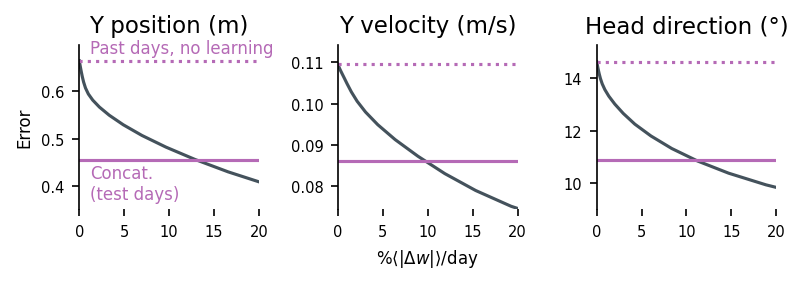

In [9]:
%matplotlib inline
from cycler import cycler
matplotlib.rcParams['axes.prop_cycle'] = cycler(color=[BLACK,RUST,TURQUOISE,OCHRE,AZURE])
matplotlib.rcParams['figure.dpi']=150

for animal, sessions in use:
    figure(figsize=(5.5,2))
    xlimit = 15
    FS = get_FS(animal,sessions[0]) # Sampling rate
    for ip,predict in enumerate([1,3,4]):
        subplot(1,3,ip+1)
        key = animal,tuple(sessions),predict
        results     = delta_rates_saved[key]
        delta_rates = results['delta_rates']
        e01         = results['e01' ]
        ac          = results['ac'  ]
        w0          = results['w0'  ]
        wbar        = results['wbar']
        ybar        = results['ybar']
        
        dr = array([r['MABSE'] for r in delta_rates])
        pd = array([r['MDWPDPCT'] for r in delta_rates])#/wbar*100*FS*60
        
        # dr: percent weight change per day
        # pd: error level (in physical units)
        plot(pd,dr)
        simpleraxis()
               
        # Error without learning
        axhline(e01,color=MAUVE,linestyle=':')
        # Concatenated error levels
        axhline(ac,color=MAUVE)
        print(animal,sessions,e01,ac)
        
        if ip==1: xlabel('%${\\left<|\Delta w|\\right>}/$day')
        if ip==0: ylabel('Error')
        title('%s (%s)'%(kininfo[predict]['name'],kininfo[predict]['units']),fontsize=11)
        x   = pixels_to_xunits(5)
        y   = e01
        dy  = pixels_to_yunits(5)
        if ip==0: text(x,y+dy,'Past days, no learning',ha='left',va='bottom',color=MAUVE,fontsize=8)
        y = ac
        if ip==0: text(x,y-dy,'Concat.\n(test days)',ha='left',va='top',color=MAUVE,fontsize=8)
        #force_aspect()
        
        # Autoscale
        y1 = ac - (e01 - ac)*0.5
        y2 = e01 + pixels_to_yunits(20)
        ylim(y1,y2)
        x1 = 0
        x2 = pd[where(dr>y1)[0][-1]]
        print(x1,x2)
        xlim(x1,x2)
        xlim(0,20)
        
    tight_layout() 
    saveto = 'constrained_LMS_rate_optimization_v6_mouse_%s_sessions_%s'%(animal,'_'.join(map(str,sessions)))
    savefigure(saveto,stamp=False)
    print('Saved to',saveto)

## Check results and pick a learning rate and Δw limit to use as a demonstration example

The `delta_rates_saved` variable should contain the results of running LMS for a range of learning rates and weight-change limits

        deltas:
            List of "deltas", i.e. weight-change limits, 
            searched over. These are set based on the typical 
            weight value from the concatenated decoder, so they
            differ for every animal and group of sessions. 
        delta_rates:
            Results are returned as an unrolled array of shape
            NRATES x NDELTAS. 
            List of results dictionaries returned by test_LMS_summary
            delta_rates. Each result should contain the following:
                RMSE:  root-mean-squared prediction error
                MABSE: mean absolute prediction error
                RMSD:  root mean squared weight change between samples
                MABSD: mean absolute change in weights between samples
                MAXD:  maximum absolute change in weights between samples
        ac:
            Mean absolute error, concatenated test
        ec01:
            Mean absolute error, pretraining
        w0:
            Initial weights
        wc: 
            Concatenated weights
        wbar:
            Mean absolute weight in concatenated fit

Weight-change limits were set heuristically based on the weight magnitudes of the concatenated decoder. There is no guarantee that the actual LMS algorithm will adopt rates of similar magnitude, and it could be that the weight change relative to the weight magnitudes during LMS could reflect a different effective % rate of change. 

## Process result

In [10]:
@memoize
def test_constrained_LMS(animal,sessions,predict,rate,delta,PRETRAIN=1,NXVAL=10,reg=0.0):
    Xtnt,Ytnt,Xtst,Ytst,sameday = prepare_data(animal,sessions,predict,PRETRAIN,NXVAL)
    Xtrain = concatenate(Xtnt)
    Ytrain = concatenate(Ytnt)
    Xtest  = concatenate(Xtst)
    Ytest  = concatenate(Ytst)
    # Concatenated baseline
    yc = trial_crossvalidated_least_squares(Xtst,Ytst,NXVAL,shuffle=True,reg=reg)[1]
    ec = Ytest - yc
    ac = mean(abs(ec))
    # Pretrain baseline
    w0 = reglstsq(Xtrain,Ytrain,reg=1e-2)
    y0 = Xtest @ w0
    e0 = Ytest - y0.ravel()
    a0 = mean(abs(ec))
    # LMS performance
    w,e,yh = run_LMS(Xtest,Ytest,w0,rate=rate,clip=delta)
    return {
        'Xtest':Xtest,
        'Ytest':Ytest,
        'sameday':sameday,
        'w' :squeeze(w),
        'e' :squeeze(e),
        'e0':squeeze(e0),
        'ec':squeeze(ec),
        'y' :squeeze(Ytest),
        'yh':squeeze(yh),
        'y0':squeeze(y0)}

try:
    LMS_results
except:
    LMS_results = {}
    
for animal, sessions in use:
    for predict in [1,3,4]:
        key = animal,tuple(sessions),predict
        print(key)
        rate = {
            1:4e-4,
            3:4e-4,
            4:4e-4}[predict]
        Ytst = prepare_data(animal,sessions,predict,PRETRAIN,NXVAL)[3]
        #scale = std(concatenate(Ytst))
        #rate = rate * scale / 1.7
        LMS_results[key]=test_constrained_LMS(animal,sessions,predict,rate,None,PRETRAIN,NXVAL)
print('Done')

(4, (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11), 1)
(4, (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11), 3)
(4, (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11), 4)
Done


## Get summary statistics

In [11]:
for animal, sessions in use:
    sessions = tuple(sessions)
    print('\n\nSubject %d sessions %s'%(animal,sessions))
    slens, edges = get_session_lengths(animal,sessions,PRETRAIN)
    
    for predict in [1,3,4]:
        print('Variable %d'%predict)
        w   = LMS_results[animal,sessions,predict]['w'][:,:-1]
        dw  = abs(diff(w,axis=0))
        maw = np.mean(abs(w))
        print('  Mean %Δw/m      ',np.mean(dw)/maw*100*FS*60)
        print('  Mean %Δw/session',np.mean(abs(diff(w[edges,:],axis=0)))/maw*100)

    # Get statistical summary
    print('All variables merged:')
    w   = concatenate([LMS_results[animal,sessions,p]['w'][:,:-1].T                   for p in [1,3,4]]).T
    dw  = concatenate([abs(diff(LMS_results[animal,sessions,p]['w'][:,:-1],axis=0)).T for p in [1,3,4]]).T 
    maw = np.mean(abs(w))
    print('  Mean %Δw/m      ',np.mean(dw)/maw*100*FS*60)
    print('  Mean %Δw/session',np.mean(abs(diff(w[edges,:],axis=0)))/maw*100)



Subject 4 sessions (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)
Variable 1
  Mean %Δw/m       3.6303788372037635
  Mean %Δw/session 13.185130906865055
Variable 3
  Mean %Δw/m       4.184158441298907
  Mean %Δw/session 15.551980417528094
Variable 4
  Mean %Δw/m       3.898190385691693
  Mean %Δw/session 14.2478854122037
All variables merged:
  Mean %Δw/m       3.888252658652084
  Mean %Δw/session 14.209579560264254


## Plot examples

4 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)
Plotting decoding examples...
Plotting weight evolution...
11.874242009409976
Plotting error evolution...


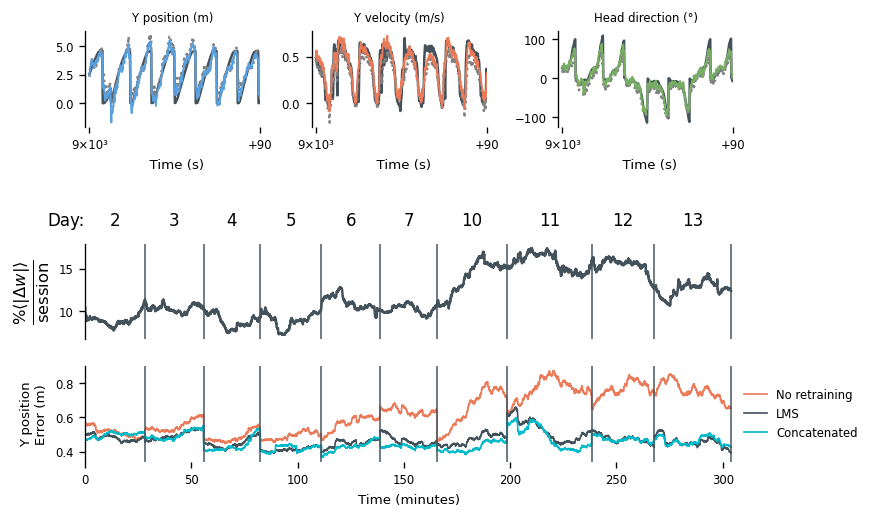

In [12]:
%matplotlib inline
matplotlib.rcParams['figure.dpi']=120

def snapshot_plot(p,color=RUST):
    '''
    Plots a short example of the kinematics,
    and its prediction via LMS
    '''
    simpleraxis()
    xlabel('  Time (s)')
    title(kininfo[p[-1]]['name']+' (%s)'%kininfo[p[-1]]['units'])
    plot(tt,LMS_results[p]['y'][t1:t2],label='True')
    plot(tt,LMS_results[p]['y0'][t1:t2],color=(0.5,0.5,0.5),linestyle=':',label='OLS')
    plot(tt,LMS_results[p]['yh'][t1:t2],color=color,lw=1.1,label='LMS')
    xticks([tt[0],tt[-1]],['%d×10³'%(tt[0]//1000),'+%d'%dt])
    xlim(xlim()[0]-0.025*diff(xlim()),xlim()[1])

# Sample rate and how much to plot
FS = 5.3
dt = 60*1.5
SMOOTH  = int(FS*60*10)

def avg_error(e):
    # dwmeans = box_filter(mean(dw,axis=1),SMOOTH)
    N = len(e)
    e = box_filter(abs(e),SMOOTH)
    return interp1d(linspace(0,N-1,len(e)),e)(arange(N))

predict = 1
for animal, sessions in use:
    sessions = tuple(sessions)
    print(animal,sessions)
    slens, edges = get_session_lengths(animal,sessions,PRETRAIN)

    key = animal,sessions,predict
    t1 = LMS_results[key]['y'].shape[0]//2
    t2 = t1 + int(dt*FS)
    tt = arange(t1,t2)/FS

    figure(figsize=(8,4.75))
    ax0 = subplot2grid((3,3),(0,0))
    ax1 = subplot2grid((3,3),(0,1))
    ax2 = subplot2grid((3,3),(0,2))
    ax3 = subplot2grid((3,3),(1,0),1,3)
    ax4 = subplot2grid((3,3),(2,0),1,3)
    subplots_adjust(wspace=0.35,hspace=0.75,right=0.8)

    # Individual examples
    print('Plotting decoding examples...')
    sca(ax0); snapshot_plot((animal,sessions,1),color=AZURE)
    sca(ax1); snapshot_plot((animal,sessions,3),color=RUST)
    nudge_axis_x(-10)
    sca(ax2); snapshot_plot((animal,sessions,4),color=MOSS)

    print('Plotting weight evolution...')
    sca(ax3)
    w       = LMS_results[key]['w']
    T       = w.shape[0]
    tt      = arange(T)/FS/60
    mabsw   = mean(abs(w))
    D       = int(mean(slens))
    Δw      = w[D:,:]-w[:-D,:]
    mabsΔw  = mean(abs(Δw),axis=1)
    mdw     = mabsΔw/mabsw*100
    mdw     = interp1d(arange(len(mdw)),mdw)(linspace(0,len(mdw)-1,T))
    print(mean(mdw))
    plot(tt[:len(mdw)],mdw,color=BLACK);
    simpleraxis()
    xlabel('')
    ylabel('$\\frac{\%\\left<|\Delta w|\\right>}{\\operatorname{session}}$',fontsize=14)
    xticks([])
    for t in edges: 
        axvline(t/FS/60,color=BLACK,lw=0.9)
    ytext = ylim()[0]+diff(ylim())*1.15
    for s,middle in zip(sessions[PRETRAIN:],0.5*(edges[1:]+edges[:-1])):
        text(middle/FS/60,ytext,'%d'%daymap[animal,s],ha='center',va='bottom')
    text(0,ytext,'Day:',ha='right',va='bottom')
    nudge_axis_y(-45)
    x1 = tt[-1]+1
    xlim(0,x1)

    print('Plotting error evolution...')
    # Reconstruction errors
    sca(ax4)
    e  = LMS_results[key]['e' ] # LMS error
    e0 = LMS_results[key]['e0'] # Single-day generalization
    ec = LMS_results[key]['ec'] # Concatenated decoder
    eq = concatenate([LMS_results[key]['sameday'][s]['e'] for s in sessions[PRETRAIN:]])
    T  = e.shape[0]
    tt = arange(T)/FS/60

    # Break into sessions and smooth within session for plotting
    plot_e0 = cat([avg_error(e0[edges[i]:edges[i+1]]) for i in range(len(sessions)-PRETRAIN)])
    plot_ec = cat([avg_error(ec[edges[i]:edges[i+1]]) for i in range(len(sessions)-PRETRAIN)])
    plot_e  = cat([avg_error(e [edges[i]:edges[i+1]]) for i in range(len(sessions)-PRETRAIN)])
    plot(tt[2:],plot_e0,lw=1,label='No retraining',color=RUST     )
    plot(tt[2:],plot_e ,lw=1,label='LMS'          ,color=BLACK    )
    plot(tt[2:],plot_ec,lw=1,label='Concatenated' ,color=TURQUOISE)

    for t in edges: 
        axvline(t/FS/60,color=BLACK,lw=0.9)
    simpleraxis()
    xlabel('Time (minutes)')
    ylabel('%s\nError (%s)'%(kininfo[predict]['name'],kininfo[predict]['units']))
    xlim(0,x1)
    rightlegend()

    savefigure('LMS_summary_v6_s%02d_sessions_%02d-%02d_%s'%(animal,sessions[0],sessions[-1],predict),stamp=False)